# Predicting the winning side of Dota2

### 1. Libraries imports

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.dummy import DummyRegressor

from sklearn.utils import check_array
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# Model assement functionality
from sklearn.model_selection import LeaveOneOut, KFold, train_test_split, cross_val_score
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

from sklearn.neural_network import MLPClassifier

### Game Modes

| id | Name                   |
|----|------------------------|
| 0  | No Game Mode           |
| 1  | All Pick               |
| 2  | Captain's Mode         |
| 3  | Random Draft           |
| 4  | Single Draft           |
| 5  | All Random             |
| 7  | Diretide               |
| 8  | Reverse Captain's Mode |
| 9  | Greeviling             |
| 10 | Tutorial               |
| 11 | Mid Only               |
| 12 | Least Played           |
| 13 | New Player Pool        |
| 14 | Compendium Matchmaking |
| 15 | Custom                 |
| 16 | Captain's Draft        |
| 17 | Balanced Draft         |
| 18 | Ability Draft          |
| 20 | All Random Deathmatch  |
| 21 | Solo Mid 1v1           |
| 22 | Ranked All Pick        |

1, 2, 3, 4, 5, 12, 16

### Data imports

In [2]:
players_data = pd.read_csv("./data/players.csv")
matches_data = pd.read_csv("./data/match.csv")
player_time_data = pd.read_csv('./data/player_time.csv')
players_data = players_data.merge(matches_data[["radiant_win", "match_id", "game_mode", 'duration']], on="match_id")


### Model selection and assesment

##### Assumptions of the model
* 1. All players play equally every hero
* 2. All players in a match are playing similiarly good
* 3. The player doesn't progress with time (k-fold estimate)

* The game mode is either all pick, single draft, all random, random draft, captain’s draft, captain’s mode, or least played.

* The skill level of the players is “very-high,” which corresponds to roughly the top 8% of players. 
* No players leave the match before the game is completed.

### Data preparation for feature vector of heroes

#### Remove data where some of the players has left or is abandoned

In [3]:
leavers_data = players_data[players_data.leaver_status != 0]
match_ids_having_left = leavers_data.match_id.unique()
left_mask = players_data['match_id'].isin(match_ids_having_left)
players_data = players_data[left_mask == False]
players_data

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue,radiant_win,game_mode,duration
0,0,0,86,0,3261,10960,347,362,9,3,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,True,22,2375
1,0,1,51,1,2954,17760,494,659,13,3,...,14.0,NaN,NaN,NaN,NaN,NaN,NaN,True,22,2375
2,0,0,83,2,110,12195,350,385,0,4,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,True,22,2375
3,0,2,11,3,1179,22505,599,605,8,4,...,13.0,NaN,NaN,NaN,NaN,NaN,NaN,True,22,2375
4,0,3,67,4,3307,23825,613,762,20,3,...,23.0,NaN,NaN,NaN,NaN,NaN,NaN,True,22,2375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,False,22,2788
499996,49999,0,9,129,3755,20815,507,607,12,6,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,False,22,2788
499997,49999,0,90,130,1059,16225,371,404,5,3,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,False,22,2788
499998,49999,0,73,131,3165,31015,780,703,8,6,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,False,22,2788


#### Remove those are playing too long

In [4]:
df = players_data[['hero_id', 'match_id', 'player_slot', 'radiant_win', 'leaver_status']]

heroes_number = df.hero_id.max()
rad_games = df[df['player_slot'] == 0][['match_id', 'hero_id']]
dir_games = df[df['player_slot'] == 1][['match_id', 'hero_id']]

# clean those who have left
# rad_games = rad_games[rad_games.leaver_status == 0]
# dir_games = dir_games[dir_games.leaver_status == 0]

rad_heroes = pd.pivot_table(rad_games, index='match_id', aggfunc=len, columns='hero_id', fill_value=0)

dir_heroes = pd.pivot_table(dir_games, index='match_id', aggfunc=len, columns='hero_id', fill_value=0)
dir_heroes.columns += heroes_number + 1

features_df = rad_heroes.merge(dir_heroes, on='match_id')

responses = df.drop_duplicates(subset='match_id', keep="last")['radiant_win']

In [297]:
def predict(vector):
    rad_prob = lr.predict(X_test.iloc[:, np.r_[:113, 111:220]])

### Model fitting and assesement

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features_df.iloc[:, np.r_[:113, 111:220]], responses,
                                                    test_size=0.10, random_state=44)
lr = LogisticRegression(penalty='l1', solver='liblinear')
clf = lr.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5516342965419233

In [22]:

indices = np.r_[:113, 111:220]
reversed_indices = np.r_[111:220, :113]

reversed_indices
rad_probs = clf.predict_proba(X_test.iloc[:, indices])[:, 1]
dir_probs = clf.predict_proba(X_test.iloc[:, reversed_indices])[:, 1]
ove_probs = (rad_probs + (1-dir_probs)) / 2
is_winning = ove_probs > 0.5
# # # is_winning
sum(is_winning == y_test) / y_test.shape[0]
# # X_test2
plot_roc_curve(clf, X_test, y_test);

0.5281856939838939

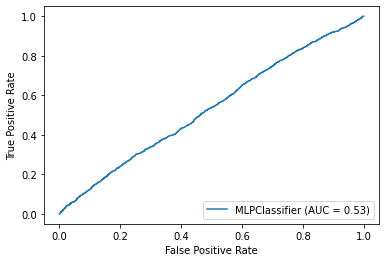

In [27]:
mlp = MLPClassifier(hidden_layer_sizes=(16,16,16), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, y_train)
plot_roc_curve(mlp, X_test, y_test);

In [286]:
%%html
<style>
table {float:left}
</style>